In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPool2D, Activation, LeakyReLU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

import kerastuner as kt

import pickle
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

print(tf.__version__, tf.test.gpu_device_name())
# tf.config.set_visible_devices([], 'GPU')

2.4.1 /device:GPU:0


In [2]:
DATA_DIRECTORY = 'Z:/fml-final/data/offline_off-policy/'

In [3]:
def state_to_features(game_state: dict) -> np.array:
    X = np.zeros((17, 17, 7), dtype=bool)

    # material
    # X[game_state["field"] == -1, 0] = True
    X[game_state["field"] == 0, 0] = True
    X[game_state["field"] == 1, 1] = True

    # explosion
    X[game_state["explosion_map"] > 0, 2] = True
    
    # add bomb countdowns for every field
    for bomb in game_state["bombs"]: X[bomb[0][0], bomb[0][1], 3] = True

    # add coin bool for every field
    for coin in game_state["coins"]: X[coin[0], coin[1], 4] = True

    # add agent info (self) for every field
    X[game_state["self"][3][0], game_state["self"][3][1], 5] = True

    # add agent info (opponent) for every field
    for opponent in game_state["others"]: X[opponent[3][0], opponent[3][1], 6] = True

    return X

In [4]:
def preprocessed_data_from_file(dir, filename):
    with open(dir + filename, "rb") as file:
        data = pickle.load(file)

    X = []
    y = []

    for transition in data:
        X.append(state_to_features(transition[0]))
        y.append(transition[1])

    return  np.array(X), np.array(y)

In [5]:
def joined_split_data_from_files(directory, filenames):
    X_train, X_test, y_train, y_test = list(), list(), list(), list()
    for filename in filenames:
        X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(*preprocessed_data_from_file(directory, filename), test_size=0.2)
        X_train.extend(X_train_new)
        X_test.extend(X_test_new)
        y_train.extend(y_train_new)
        y_test.extend(y_test_new)
    
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [6]:
def array_splits_of_size(N, array):
    return np.array_split(array, len(array) // N)

In [7]:
def build_model(hp):
    classifier = Sequential()

    conv_size = hp.Int("conv size 1", min_value=2, max_value=6)
    classifier.add( Conv2D(hp.Choice("conv features 1", [8, 16, 32, 64, 128, 256, 512]), (conv_size, conv_size), input_shape=(17, 17, 7)) )
    classifier.add( LeakyReLU() )
    classifier.add( MaxPool2D(2, 2) )
    classifier.add( Dropout(0.2) )

    for i in range(hp.Int("additional conv layers", min_value=0, max_value=2)):
        conv_size = hp.Int(f"conv size {i}", min_value=2, max_value=6)

        classifier.add( Conv2D(hp.Choice(f"conv features {i}", [8, 16, 32, 64, 128, 256, 512]), (conv_size, conv_size)) )
        classifier.add( LeakyReLU() )
        classifier.add( MaxPool2D(2, 2) )
        classifier.add( Dropout(0.2) )

    classifier.add( Flatten() )

    classifier.add( Dense(hp.Choice("dense units 1", [64, 128, 256, 512, 1024, 2048])) )
    classifier.add( LeakyReLU() )
    classifier.add( Dropout(0.2) )
    
    for i in range(hp.Int("additional dense layers", min_value=0, max_value=4)):
        classifier.add( Dense(hp.Choice(f"dense units {i}", [8, 16, 32, 64, 128, 256, 512])) )
        classifier.add( LeakyReLU() )
        classifier.add( Dropout(0.2) )

    classifier.add( Dense(6, activation="softmax") )
    classifier.compile(loss=hp.Choice("loss function", ["categorical_crossentropy", "sparse_categorical_crossentropy"]), optimizer=Adam(lr=0.002), metrics=["accuracy"])

    return classifier

In [8]:
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=4,
    directory='./conv_net_classifier_1_tuner',
    project_name='ConvNetClassifier'
)

INFO:tensorflow:Reloading Oracle from existing project ./conv_net_classifier_1_tuner\ConvNetClassifier\oracle.json


In [9]:
X_train, X_test, y_train, y_test = joined_split_data_from_files(DATA_DIRECTORY, os.listdir(DATA_DIRECTORY)[:11])

KeyboardInterrupt: 

In [10]:
tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=32)


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
conv size 1       |2                 |?                 
conv features 1   |8                 |?                 
additional conv...|0                 |?                 
dense units 1     |1024              |?                 
additional dens...|3                 |?                 
loss function     |categorical_cro...|?                 



ValueError: Data cardinality is ambiguous:
  x sizes: 880994
  y sizes: 220257
Make sure all arrays contain the same number of samples.

In [8]:
# loss_history = []
# val_accuracy_history = []

In [9]:
# for i in range(2):
#     for filenames in tqdm(array_splits_of_size(5, os.listdir(DATA_DIRECTORY))):
#         X_train, X_test, y_train, y_test = joined_split_data_from_files(DATA_DIRECTORY, filenames)
#         hist = classifier.fit(X_train, tf.one_hot(y_train, 6), epochs=1, batch_size=32, shuffle=True, verbose=True, validation_data=(X_test, tf.one_hot(y_test, 6))).history
#         loss_history.extend(hist["loss"])
#         val_accuracy_history.extend(hist["val_accuracy"])

  0%|          | 0/15 [01:01<?, ?it/s]


KeyboardInterrupt: 

In [13]:
# classifier.save("conv_net_classifier_1")

INFO:tensorflow:Assets written to: conv_net_classifier_0\assets


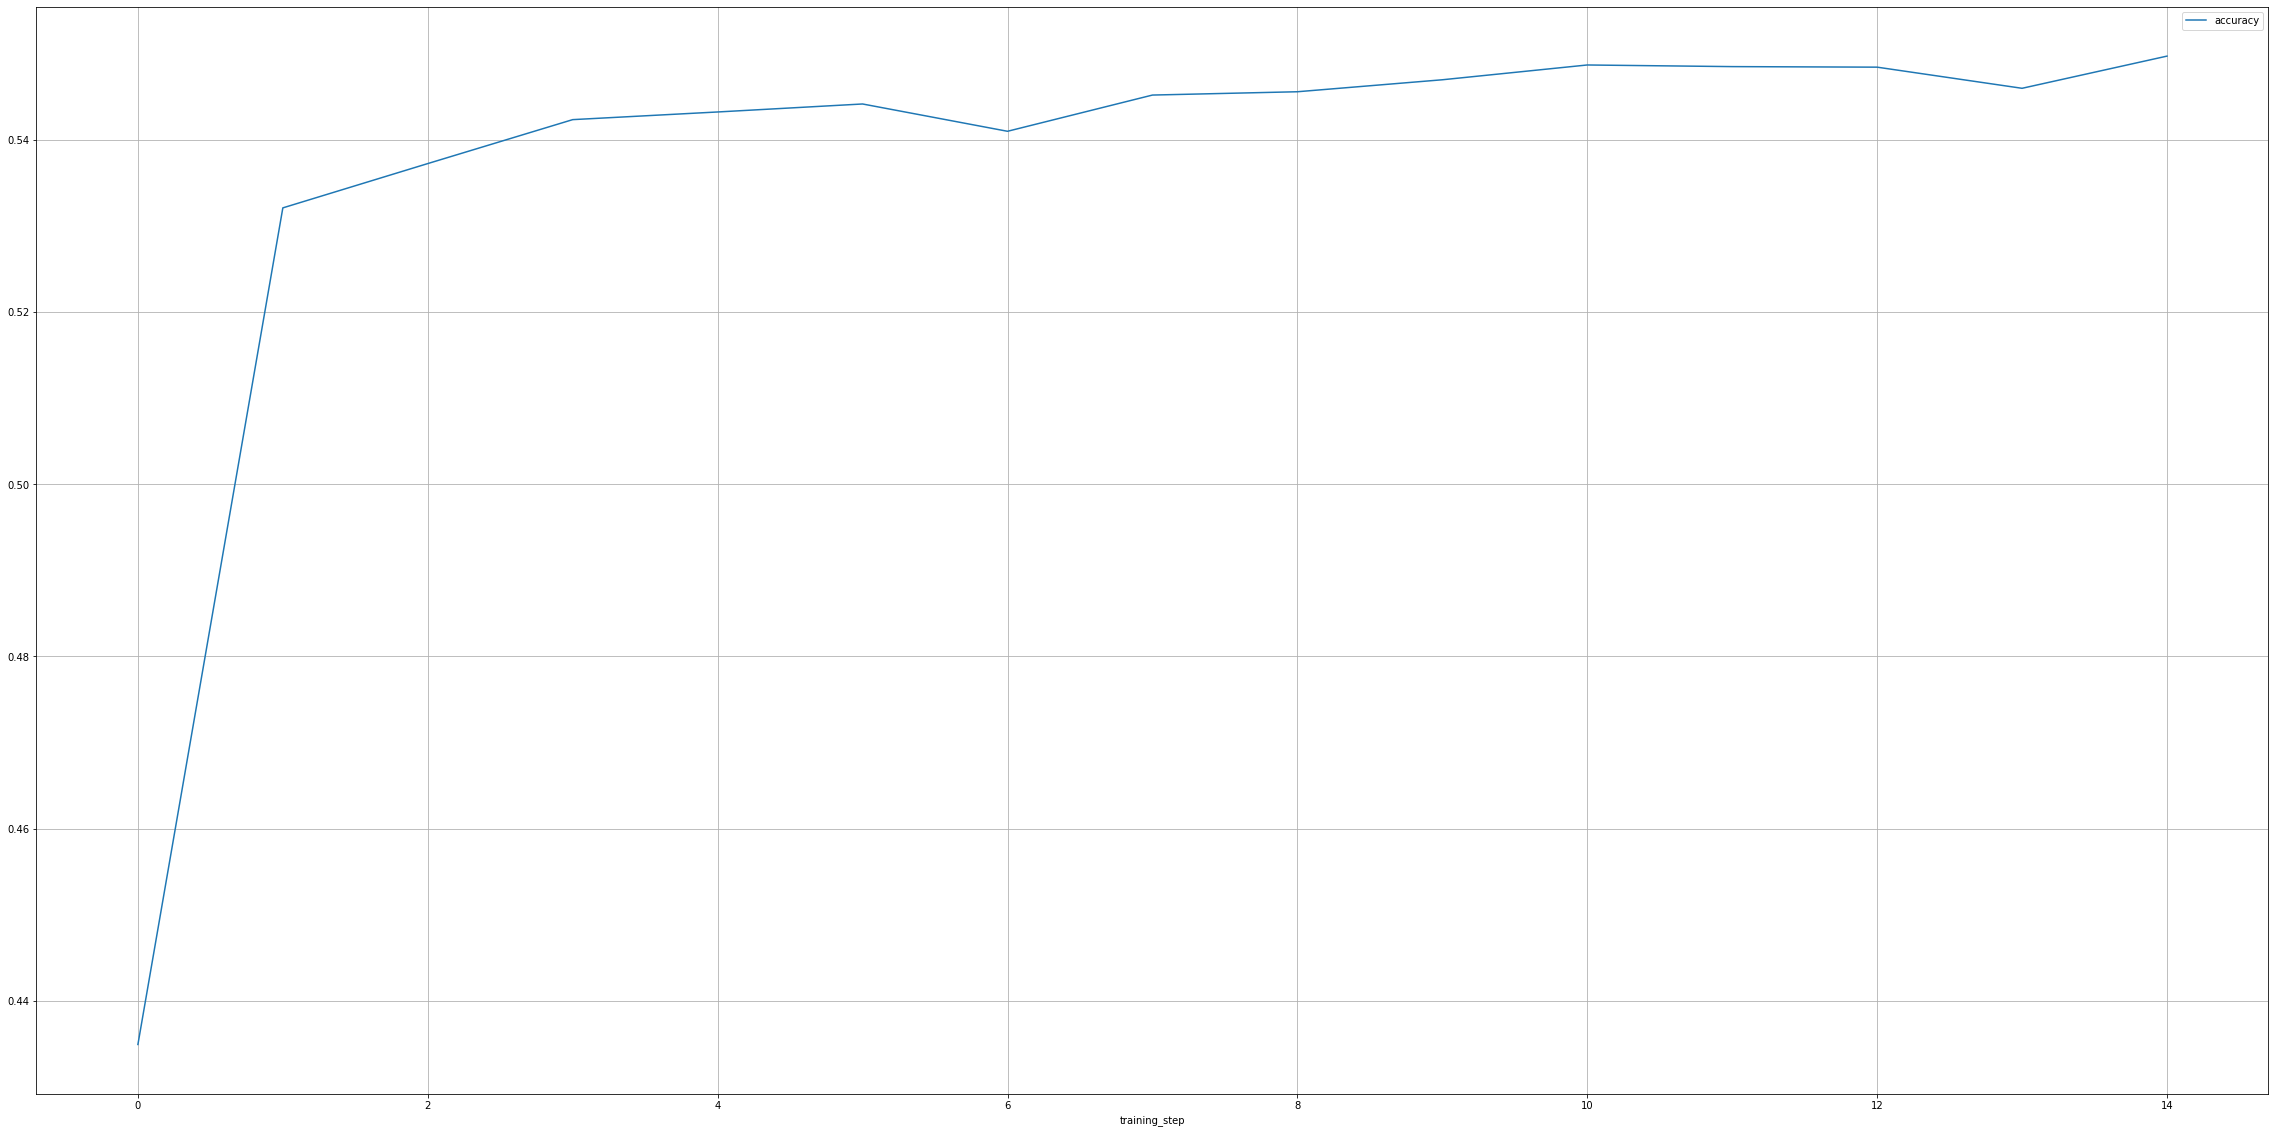

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(40, 20))
# ax.plot(np.arange(len(loss_history)), loss_history, label="loss", alpha=0.5)
ax.plot(np.arange(len(val_accuracy_history)), val_accuracy_history, label="accuracy")
ax.set_xlabel("training_step")
ax.grid("y")
ax.legend();